<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第4章：从零实现GPT模型生成文本

In [91]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.9.4
torch version: 2.7.1+cu118
tiktoken version: 0.9.0


- 本章我们将实现一个类似GPT的大语言模型架构；下一章将重点训练这个模型

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 实现大语言模型架构

- 第1章讨论了GPT和Llama等模型，这些模型顺序生成单词，并基于原始Transformer架构的解码器部分
- 因此，这些大语言模型通常被称为’类解码器’模型
- 与传统深度学习模型相比，大语言模型规模更大，这主要源于其海量参数，而非代码量
- 我们会发现大语言模型架构中存在许多重复元素

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- 在前几章中，我们使用了较小的嵌入维度来处理token输入和输出，以便于说明，确保内容能放在单页上
- 本章我们将采用类似于小型GPT-2模型的嵌入维度和模型规模
- 我们将具体实现最小的GPT-2模型架构(1.24亿参数)， 如Radford等人的论文[Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) (注：初始报告列为1.17亿参数，后在模型权重库中更正)
- 第6章将展示如何将预训练权重加载到我们的实现中，这将兼容3.45亿、7.62亿和15.42亿参数的模型规模

- 1.24亿参数GPT-2模型的配置详情如下：

In [92]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- 我们使用简短的变量名以避免后续代码行过长
- `"vocab_size"` 表示50,257词的词汇表大小，由第2章讨论的BPE分词器支持
- `"context_length"` 表示模型的最大输入token数，通过第2章介绍的位置编码实现
- `"emb_dim"` 是token输入的嵌入维度，将每个输入token转换为768维向量”
- `"n_heads"` 是第3章实现的多头注意力机制中的注意力头数量
- `"n_layers"` 表示模型中Transformer块的数量，我们将在后续章节实现
- `"drop_rate"` 是dropout机制的强度(第3章讨论过)，0.1表示训练期间丢弃10%的隐藏单元以防止过拟合
- `"qkv_bias"` 决定多头注意力机制(第3章)中的Linear层在计算查询(Q)、键(K)和值(V)张量时是否包含偏置向量；我们将禁用此选项，这是现代大语言模型的标准做法；不过在第5章将OpenAI的预训练GPT-2权重加载到我们的实现时，会重新讨论这个问题

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

In [93]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

In [94]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [95]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**注意**

- 如果你在 Windows 或 Linux 上运行此代码, 上述结果值可能如下所示：
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 由于这些只是随机数，因此不需要担心，你可以继续阅读本章的其余部分而不会出现问题。
- 这种差异的一种可能原因是 nn.Dropout 在不同操作系统上的行为不同，这取决于 PyTorch 的编译方式，如讨论所示 [here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)

---

## 4.2 使用层归一化对激活进行归一化

- 层归一化（LayerNorm），也称为层归一化 ([Ba et al. 2016](https://arxiv.org/abs/1607.06450)), 将神经网络层的激活值的均值调整为0，并将其方差归一化为1。
- 这有助于稳定训练，并加快收敛到有效的权重。
- 层归一化在转换器块中的多头注意力模块前后都会应用，我们稍后会实现这个模块；它也会在最终输出层之前应用。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- 让我们通过将一个小的输入样本传递通过一个简单的神经网络层来观察层归一化是如何工作的：

In [96]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 让我们计算上述每个输入的均值和方差：

In [97]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 归一化对两个输入（行）独立进行；使用 dim=-1 会在最后一个维度（在这个例子中是特征维度）上应用计算，而不是在行维度上。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

- 减去均值并除以方差的平方根（标准差），可以使输入在列（特征）维度上具有均值为0和方差为1的特性：

In [98]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 每个输入的均值为0，方差为1；为了提高可读性，我们可以禁用 PyTorch 的科学计数法：

In [99]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 上述内容中，我们对每个输入的特征进行了归一化。
- 现在，使用相同的思想，我们可以实现一个 LayerNorm 类：

In [100]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**缩放和平移**

- 注意，除了通过减去均值并除以方差进行归一化外，我们还添加了两个可训练参数，即 `scale` 和 `shift` 参数。
- 初始的 `scale` (乘以1) 和 `shift` (加0) 值没有任何效果；然而， `scale` 和 `shift` a是可训练参数，LLM 会在训练过程中自动调整这些参数，如果发现这样做可以提高模型在其训练任务上的性能。
- 这使得模型能够学习最适合其处理数据的缩放和平移。
- 注意，我们在计算方差的平方根之前还添加了一个较小的值 (`eps`) ；这是为了避免在方差为0时出现除以零的错误。

**Biased variance有偏方差**
- 在上面的方差计算中，设置 `unbiased=False` 表示使用公式  $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 来计算方差，其中n 是样本大小 (在这里，特征或列的数量); 该公式不包含贝塞尔校正（即在分母中使用 n-1），因此提供了有偏的方差估计。
- 对于 LLMs，其嵌入维度 `n` 非常大时，使用 `n` 和 `n-1` 之间的差异可以忽略不计。
- 然而，GPT-2 在归一化层中使用了有偏方差进行训练，因此我们也采用了这种设置以兼容稍后章节中加载的预训练权重。
- 现在让我们在实践中试用 LayerNorm：

In [101]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [102]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

## 4.3 使用 GELU 激活函数实现前馈网络

- 在本节中，我们将实现一个小型神经网络子模块，该子模块在 LLMs 的转换器块中使用
- 我们从激活函数开始。
- 在深度学习中， ReLU (Rectified Linear Unit) 激活函数因其简单性和在各种神经网络架构中的有效性而被广泛使用。
- 在 LLMs 中，除了传统的 ReLU，还使用了各种其他类型的激活函数；两个值得注意的例子是 GELU（Gaussian Error Linear Unit）和 SwiGLU（Swish-Gated Linear Unit）。
- GELU 和 SwiGLU 是更复杂、更平滑的激活函数，分别结合了高斯单位和 sigmoid 门控线性单位，为深度学习模型提供了更好的性能，而 ReLU 是一个更简单、分段线性的函数。

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) 可以通过多种方式实现；其确切版本定义为 GELU(x)=x⋅Φ(x), 其中  Φ(x) 是标准高斯分布的累积分布函数。
- 在实践中，通常会实现一个计算成本较低的近似版本： $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (原始的 GPT-2 模型也使用了这种近似方法进行训练)

In [103]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

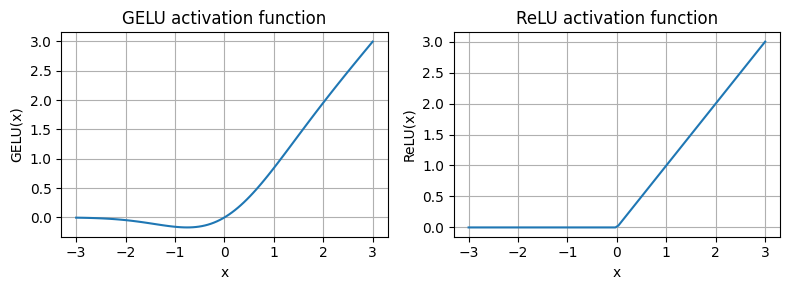

In [104]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 如我们所见，ReLU 是一个分段线性函数，如果输入为正，则直接输出输入值；否则输出零。
- GELU 是一个平滑的非线性函数，近似于 ReLU，但在负值时具有非零梯度（除了大约在 -0.75 处）。
- 接下来，让我们实现一个小型神经网络模块 `FeedForward`，我们稍后将在 LLM 的转换器块中使用它：

In [105]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [106]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [107]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4 添加快捷连接

- 接下来，让我们谈谈快捷连接的概念，也称为跳跃连接或残差连接。
- 原始的跳跃连接是在计算机视觉的深度网络（残差网络）中提出的，以缓解梯度消失问题。
- 跳跃连接为梯度在网络中流动提供了替代的较短路径。
- 这是通过将一个层的输出添加到后面某个层的输出来实现的，通常会跳过中间的一层或更多层。
- 让我们用一个小示例网络来说明这个想法：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- 在代码中，快捷连接的实现如下：

In [108]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # 计算当前层的输出
            layer_output = layer(x)
            # 检查是否可以应用快捷连接
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # 前向传播
    output = model(x)
    target = torch.tensor([[0.]])

    # 根据目标和输出的接近程度计算损失
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # 反向传播以计算梯度
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 印权重的平均绝对梯度
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 首先让我们打印 **不使用** 快捷连接时的梯度值：

In [109]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


- 接下来，让我们打印 **使用** 快捷连接梯度值:

In [110]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


- 根据上面的输出，我们可以看到快捷连接可以防止梯度在早期层（靠近  `layer.0` ）中消失。
- 我们将在接下来实现转换器块时使用这个快捷连接的概念。

## 4.5 在转换器块中连接注意力层和线性层

- 在本节中，我们将之前的概念结合起来，形成所谓的转换器块。
- 转换器块将上一章中的因果多头注意力模块与线性层和我们之前实现的前馈神经网络结合在一起。
- 此外，转换器块还使用了 dropout 和快捷连接。

In [111]:
# 如果 `previous_chapters.py` 文件不在本地，
# 你可以从 `llms-from-scratch` PyPI 包中导入它。
# 详情见：https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 例如，
# from llms_from_scratch.ch03 import MultiHeadAttention

from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 注意力块的快捷连接
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # 形状 [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # 加回原始输入

        # 前馈网络块的快捷连接
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 加回原始输入

        return x


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- 假设我们有2个输入样本，每个样本包含6个标记，其中每个标记是一个768维的嵌入向量；那么这个转换器块将首先应用自注意力机制，然后是线性层，以生成一个类似大小的输出。
- 你可以将输出视为我们在上一章讨论的上下文向量的增强版本。

In [112]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 编码 GPT 模型

- 我们已经接近目标：现在让我们将转换器块插入到我们在本章开头编写的架构中，以获得一个可用的 GPT 架构。
- 请注意，转换器块会被重复多次；在最小的124M GPT-2模型中，我们重复了12次。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- 对应的代码实现，其中 `cfg["n_layers"] = 12`:

In [113]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 使用124M参数模型的配置，我们现在可以实例化这个 GPT 模型，并使用随机初始权重，如下所示：

In [114]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- 我们将在下一章训练这个模型。
- 但是，关于其大小，我们之前将其称为一个124M参数的模型；我们可以如下验证这个数字：

In [115]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 如上所示，这个模型有163M参数，而不是124M参数；为什么？
- 在原始的 GPT-2 论文中，研究人员应用了权重绑定（weight tying），这意味着他们重用了标记嵌入层 (`tok_emb`) 作为输出层，即设置 `self.out_head.weight = self.tok_emb.weight`。
- 标记嵌入层将50,257维的独热编码输入转换为768维的嵌入表示。
- 输出层将768维的嵌入重新投影到50,257维的表示，以便我们可以将这些表示转换回单词（更多内容将在下一节中介绍）。
- 因此，嵌入层和输出层具有相同的权重参数数量，我们可以通过查看它们的权重矩阵形状来观察这一点。
- 然而，关于其大小，我们之前将其称为一个124M参数的模型；我们可以如下验证这个数字：

In [116]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- 在原始的 GPT-2 论文中，研究人员重用了标记嵌入矩阵作为输出矩阵。
- 因此，如果我们减去输出层的参数数量，我们将得到一个124M参数的模型：

In [117]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- 在实践中，我发现不使用权重绑定（weight-tying）更容易训练模型，因此在这里没有实现它。
- 然而，我们将在第5章加载预训练权重时重新审视并应用这个权重绑定的想法。
- 最后，我们可以如下计算模型的内存需求，这可以作为一个有用的参考点：

In [118]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- 练习：你可以尝试以下其他配置，这些配置在 [GPT-2 论文](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C) 中有提到。

    - **GPT2-small** (我们已经实现的124M配置):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 生成文本

- 类似于我们上面实现的 GPT 模型这样的大语言模型（LLMs）是逐词生成文本的。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- 以下的 `generate_text_simple` 函数实现了贪心解码（greedy decoding），这是一种简单而快速的生成文本的方法。
- 在贪心解码中，每一步模型选择概率最高的词（或标记）作为其下一个输出（最高概率对应的最高 logit，所以我们实际上甚至不需要显式地计算 softmax 函数）。
- 在下一章中，我们将实现一个更高级的 `generate_text` 函数。
- 下图描绘了 GPT 模型如何在给定输入上下文的情况下生成下一个词标记。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [119]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- 上面的 `generate_text_simple` 实现了一个迭代过程，每次生成一个标记

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- 让我们准备一个输入示例：

In [120]:
start_context = " 有点意思的句子。"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [42164, 231, 163, 224, 117, 35707, 237, 45250, 251, 21410, 20998, 98, 36310, 16764]
encoded_tensor.shape: torch.Size([1, 14])


In [121]:
model.eval() # disable dropout

out = generate_text_simple(
    
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[42164,   231,   163,   224,   117, 35707,   237, 45250,   251, 21410,
         20998,    98, 36310, 16764, 44963, 45276, 26088,  2684, 25401, 25528]])
Output length: 20


- 移除批次维度并转换回文本：

In [122]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

 有点意思的句子。 Styles Sustainable Christine prim OTHER Acts


- 请注意，该模型尚未训练；因此，上面的输出文本是随机的。
- 我们将在下一章训练该模型。

## 概要和要点

- 请参阅 [./gpt.py](./gpt.py) 脚本，该脚本包含我们在本 Jupyter Notebook 中实现的 GPT 模型。
- 你可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到练习的解决方案。